In [1]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import tensorflow as tf
from keras.utils import np_utils

import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD

In [2]:
# Helper to plot loss
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.legend()
  plt.grid(True)

# Keras, TensorFlow, and Neural Network Regression

As we have seen, neural networks aren't quite as complex as they appear at first, however we still generally don't want to have to build them from scratch very often. The libraries that we will primarily use for creating neural network models are Tensorflow and Keras. 

### Tensorflow

Tensorflow, developed by Google, is one of the most popular libraries for neural networks. 

### Keras

Keras is another package that provides an an API offering an easier to use interface to Tensorflow, allowing us to use it with code that is higher level, avoiding much of the linear math that can make Tensorflow frustrating. Since its introduction Keras has been wrapped in with Tensorflow and the two are normally now blended together as far as we are concerned. 

### Other Alternatives

Keras and Tensorflow are not the only libraries of neural networks, the primary competitor to Tensorflow is PyTorch, which was developed by Facebook. PyTorch does pretty much the same thing as Tensorflow, we won't look at it. 

In [3]:
df = pd.read_csv("data/house_data.csv")
df.tail()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
21608,360000.0,3,2.50,1530,1131,3.0,0,0,3,8,1530,0,2009,0,98103,47.6993,-122.346,1530,1509
21609,400000.0,4,2.50,2310,5813,2.0,0,0,3,8,2310,0,2014,0,98146,47.5107,-122.362,1830,7200
21610,402101.0,2,0.75,1020,1350,2.0,0,0,3,7,1020,0,2009,0,98144,47.5944,-122.299,1020,2007
21611,400000.0,3,2.50,1600,2388,2.0,0,0,3,8,1600,0,2004,0,98027,47.5345,-122.069,1410,1287
21612,325000.0,2,0.75,1020,1076,2.0,0,0,3,7,1020,0,2008,0,98144,47.5941,-122.299,1020,1357


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          21613 non-null  float64
 1   bedrooms       21613 non-null  int64  
 2   bathrooms      21613 non-null  float64
 3   sqft_living    21613 non-null  int64  
 4   sqft_lot       21613 non-null  int64  
 5   floors         21613 non-null  float64
 6   waterfront     21613 non-null  int64  
 7   view           21613 non-null  int64  
 8   condition      21613 non-null  int64  
 9   grade          21613 non-null  int64  
 10  sqft_above     21613 non-null  int64  
 11  sqft_basement  21613 non-null  int64  
 12  yr_built       21613 non-null  int64  
 13  yr_renovated   21613 non-null  int64  
 14  zipcode        21613 non-null  int64  
 15  lat            21613 non-null  float64
 16  long           21613 non-null  float64
 17  sqft_living15  21613 non-null  int64  
 18  sqft_l

In [5]:
y = np.array(df["price"]).reshape(-1,1)
X = np.array(df.drop(columns={"price"}))
print(X.shape, y.shape)
X_train, X_test, y_train, y_test = train_test_split(X, y)

(21613, 18) (21613, 1)


## Create Model

Creating a NN model is slightly different from the normal process that we are used to in sklearn. We need to do a little more work to set it up. 

### Create Model and Add Layers

First we need to make a NN model, it comes "empty". We will use a sequential model, which is the most simple type but is less configurable (which we don't care about much right now). The limitation of sequential models is that they can only take in one tensor and only output one tensor. The other options here are "functional", which allows for the structure of the model to be configured, and "model subclassing", which allows you to build almost everything from scratch. These other types are more complex and more flexible, but actually aren't really needed for most applications, and we won't use them. These more complex models are commonly used for scenarios where the data is complex, such as a self driving car - a model needs to output steering as well as velocity. Also for more complex problems such as language or image processing, this flexibility allows for models to be created that are better able to extract the information from the data.

#### Layers

Next we need to add some layers. We will start simple with only two "thinking" layers, and one to do some processing. We can think of the layers roughly like steps of the sklearn pipeline, with data entering at the first layer and predictions flowing out of the final layer. 

In addition to "normal" neural network layers, there are many other types that can do all kinds of other stuff. One example we will use here is the normalization one at the front. This layer does exactly what you'd expect - it normalizes our data so the rest of the network can use it. The normalize layer will also automatically handle the 2D nature of the data that we are used to, so we don't need to worry about that aspect here. Other layers can do everything from regularization to image processing, they are also commonly inhierited for developers to create custom layers targeting specific tasks. We'll use a few of the other ones as we move through things. 

#### Dense Layers

We'll use dense layers here. When adding the layer we need to specify a couple of things. One is the input dimensions - we need to tell the network what the shape of the incomming data is. 

The other argument is the units, which represents the output dimension. When using these Keras dense layers we don't need to specify each layer's input/output like we did when we made it by hand. We specify both, using units and input_dim, for the first layer that takes in the input; for subsequent layers we can just specify the output and Keras will automatically figure the rest out. 

Note that there is also an input layer that can be added, we can avoid the need for it by using the input_dim or input_shape as shown below. The two examples there do the same thing, since the input is flat - 18 features. If we are dealing with inputs that do not start out as flat, such as in an image, use the input_shape since you can specify all dimensions; we will see an example of this next time with some images. 

#### Activation Function

For each of our layers we need to define which activation function to use. For now we will use the ReLU function, which is probably the most popular. We'll look at other ones later on. Note that we've left the activation function off of the final layer - we are doing regression so we want that raw value. This is the same idea as with linear regression - we don't want the prediction to be transformed through something like the sigmoid, we just want the number.

#### Summary

After we've constructed the model, the summary command give us, well, a summary. 

We are dealing with a bunch of numerical inputs here, so we can add a normalization layer at the front end. Like with sklearn, we want to fit the normalization to the training data only. 

In [6]:
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(X_train))

model = Sequential()
model.add(normalizer)
model.add(Dense(18, input_shape=(18,), activation='relu'))
#model.add(Dense(18, input_dim=18, activation='relu'))
model.add(Dense(1))
model.summary()

2023-02-21 13:13:53.223061: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 18)               37        
 n)                                                              
                                                                 
 dense (Dense)               (None, 18)                342       
                                                                 
 dense_1 (Dense)             (None, 1)                 19        
                                                                 
Total params: 398
Trainable params: 361
Non-trainable params: 37
_________________________________________________________________


#### Compile Model

Once a model is created we need to compile it. The complie step basically builds the layers we specified above and the loss and optimization parameters below together into a usable model object. When compiling the model we are providing it with the things it needs to calculate error:

<ul>
<li> Loss - we can provide a loss function that we'd like to use. 
<li> Optimizer - the optimizer is the algorithm that the model will use to perform the gradient descent to find the lowest error. Adam is a very common choice.
<li> Learning rate - the learning rate is provided as a parameter of the optimizer. 
</ul>

##### Optimizing Adam

The optimizer is the algorithm used to perform the gradient descent and minimize error. For the most part this isn't something we need to be concerned about. The choice of optimizer is much more important if dealing with very large datasets because different optimizers have different levels of efficiency. For our purposes, we can use Adam and be pretty happy. Adam stands for Adaptive Moment Estimation which means basically that it will adjust itself depending on current gradients. It tends to be efficient both in time and memory, so it is very commonly used. 

In [7]:
model.compile(loss='mean_absolute_error', optimizer=tf.optimizers.Adam(learning_rate=.01))

### Fit the Model

The fit command does the same thing that we are used to, it trains the model, however there are some differences. The main difference is that batch_size is almost always set in neural networks, while the sklearn models just take all the data at once. 

What's a batch? Batches are just subsets of the data, so if the batch size is 100 the algorithm will grab 100 rows at a time before making an update to the weights and bias. There are a few reasons this exists:

<ul>
<li> Memory constraints - it is common with neural networks to deal with datasets that are extremely large. Processing data that can't fit entirely in RAM is very slow (the computer must swap data from the hard drive to RAM as it is needed) compared to data that is in RAM. Cutting the batch size can avoid this issue. 
<li> Speed - the math involved in the back propagation can sometimes be very computationally intensive. 
<li> Accuracy - batch size can have an impact on accuracy, though that impact is not very predictable. For the most part finding an optimal batch size will need to be grid-searched. 
</ul>

The fit command also has the epoch paramater, which instructs on how many times to work through ALL of the data. We want to ensure we have enough epochs to find the optimal solution. Training rounds, or epochs, are one of the key tuning factors when using neural networks. Similar to large trees, large neural networks are capable of learning the training data very well, and carry the same risk of overfitting. With neural networks, a common approach to tuning is to allow the model to train, and cut it off when we start overfitting, or when the testing accuracy starts to decrease.

#### Plot the Loss

One very common visualization we see with neural networks is a plot of both training and validation loss vs number of epochs. Generally we'll see the training loss drop - first sharply as the model initially fits itself, then more slowly as it becomes more fitted. The validation loss will usually somewhat mirror the training loss, except it will often reach a minimum at some point before again increasing. This minimum point is our best model, when the validation loss starts increasing again, that is a sign that the model has become overfitted - customized to the training data, but less and less generalizable to new data. 

Set the verbosity to 1 in the fit to get a full list of the loss for each epoch to pinpoint the exact "ideal" number of epochs. We'll look more at this in a minute. 

Epoch 1/1000
130/130 [==============================] - 1s 2ms/step - loss: 537760.5625 - val_loss: 550023.8750
Epoch 2/1000
130/130 [==============================] - 0s 2ms/step - loss: 537357.8750 - val_loss: 549338.8125
Epoch 3/1000
130/130 [==============================] - 0s 2ms/step - loss: 536394.5625 - val_loss: 548096.0000
Epoch 4/1000
130/130 [==============================] - 0s 2ms/step - loss: 534909.0625 - val_loss: 546350.0625
Epoch 5/1000
130/130 [==============================] - 0s 1ms/step - loss: 532942.6875 - val_loss: 544134.6250
Epoch 6/1000
130/130 [==============================] - 0s 2ms/step - loss: 530518.8125 - val_loss: 541476.6875
Epoch 7/1000
130/130 [==============================] - 0s 1ms/step - loss: 527661.6250 - val_loss: 538388.8125
Epoch 8/1000
130/130 [==============================] - 0s 1ms/step - loss: 524394.0000 - val_loss: 534895.1250
Epoch 9/1000
130/130 [==============================] - 0s 1ms/step - loss: 520733.6250 - val_loss: 5310

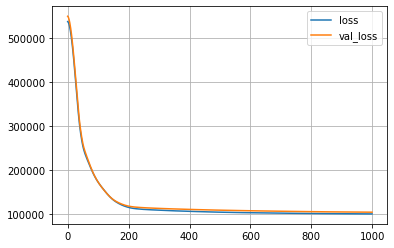

In [8]:
train_log = model.fit(X_train, y_train, epochs=500, batch_size=100, validation_split=.2, verbose=1)
model.evaluate(X_test, y_test)
plot_loss(train_log)

### Exercise

Make a simple neural network for predicting the price of homes in California. 

In [9]:
from sklearn.datasets import fetch_california_housing

cal = fetch_california_housing(as_frame=True)
Xcal = pd.DataFrame(cal.data)
ycal = pd.DataFrame(cal.target)
Xcal.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


In [10]:
X_train_cal,  X_test_cal, y_train_cal, y_test_cal = train_test_split(Xcal, ycal)
X_train_cal.shape

(15480, 8)

In [11]:
cal_normalizer = tf.keras.layers.Normalization(axis=-1)
cal_normalizer.adapt(np.array(X_train_cal))

cal_model = Sequential()
cal_model.add(cal_normalizer)
cal_model.add(Dense(8, input_shape=(8,), activation='relu'))
cal_model.add(Dense(8, activation='relu'))
cal_model.add(Dense(1))
cal_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_1 (Normalizat  (None, 8)                17        
 ion)                                                            
                                                                 
 dense_2 (Dense)             (None, 8)                 72        
                                                                 
 dense_3 (Dense)             (None, 8)                 72        
                                                                 
 dense_4 (Dense)             (None, 1)                 9         
                                                                 
Total params: 170
Trainable params: 153
Non-trainable params: 17
_________________________________________________________________


Epoch 1/100
248/248 [==============================] - 2s 5ms/step - loss: 4.0834 - val_loss: 1.1671
Epoch 2/100
248/248 [==============================] - 0s 2ms/step - loss: 1.1068 - val_loss: 0.8129
Epoch 3/100
248/248 [==============================] - 0s 1ms/step - loss: 0.8408 - val_loss: 0.7013
Epoch 4/100
248/248 [==============================] - 0s 1ms/step - loss: 0.6903 - val_loss: 0.6170
Epoch 5/100
248/248 [==============================] - 0s 2ms/step - loss: 0.5882 - val_loss: 0.5599
Epoch 6/100
248/248 [==============================] - 0s 1ms/step - loss: 0.5287 - val_loss: 0.5226
Epoch 7/100
248/248 [==============================] - 0s 1ms/step - loss: 0.4927 - val_loss: 0.4995
Epoch 8/100
248/248 [==============================] - 0s 1ms/step - loss: 0.4673 - val_loss: 0.4774
Epoch 9/100
248/248 [==============================] - 0s 1ms/step - loss: 0.4465 - val_loss: 0.4618
Epoch 10/100
248/248 [==============================] - 0s 1ms/step - loss: 0.4287 - val_lo

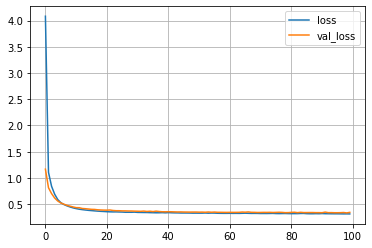

In [12]:
cal_model.compile(loss='mean_squared_error', optimizer=tf.optimizers.Adam())
cal_train_log = cal_model.fit(X_train_cal, y_train_cal, epochs=100, batch_size=50, validation_split=.2, verbose=1)
cal_model.evaluate(X_test_cal, y_test_cal)
plot_loss(cal_train_log)

## Basics of Overfitting and Underfitting in Neural Networks

Just like any other type of model, our primary task in trying to attain an accurate set of predictions is to balance the overfitting and underfitting. In a neural network, the ideas are the same as with standard models, however the tools and their usage can differ slightly. 

### Add Data

Adding data to the training set is the number one way to improve accuracy. As noted above, neural networks are commonly able to acheive very high accuracy levels if provided with very large training sets. For smaller datasets, the probability of a neural network being the best model is much lower than with big data. There isn't a replacement for having large amounts of data (though there are a few tricks that we'll look at later), and modern large neural networks are (usually) the best tool that is able to take advantage of all that data. 

In the near future we'll look at some common pre-trained models that people/orgs such as Google have shared, most notably ones that do things like image recognition. These models are typically trained on really large datasets - often 10s of GB or more. This massive amount of training data allows these models to be more accurate than anything that we could create, but would be unrealistic for most people to train just due to the processing power and time needed. We can take them and adjust them a bit to our needs though...

### Model Capacity

The model capacity is the "size" of the model - refering to the combination of the number of neurons on each layer and the number of layers. 

In general the larger a feature set is, the larger a capacity we will need to be able to avoid underfitting and make accurate predictions. However, similar to a decision tree, if the model becomes too large for the data, we are likely to overfit. 

In big data scenarios (e.g. Google or Tesla training image recognition models) the feature sets can be massive (e.g. a 5 megapixel image is at least 15 million features) so the networks used have a very high capacity. Because there is a lot of training data, the model is able to have a huge capacity, but not overfit. These models can take FOREVER to process (e.g. weeks with the work paralellized on dedicated and fast machines) but they are able to make very accurate predictions since they get all the "benefits" of overfitting - predictions highly tailored to the training data; along with all the "benefits" of underfitting - since there is so much training data, they are still generalized enough to predict new data. 

The combination of large datasets, deep networks, and fast processing allows for most of the modern AI that we see or interact with. 

In [13]:
#Test Different Model Capacities
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(X_train))

model = Sequential()
model.add(normalizer)
model.add(Dense(128, input_dim=18, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(1))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_2 (Normalizat  (None, 18)               37        
 ion)                                                            
                                                                 
 dense_5 (Dense)             (None, 128)               2432      
                                                                 
 dense_6 (Dense)             (None, 128)               16512     
                                                                 
 dense_7 (Dense)             (None, 128)               16512     
                                                                 
 dense_8 (Dense)             (None, 128)               16512     
                                                                 
 dense_9 (Dense)             (None, 1)                 129       
                                                      

169/169 [==============================] - 0s 2ms/step - loss: 71213.1719


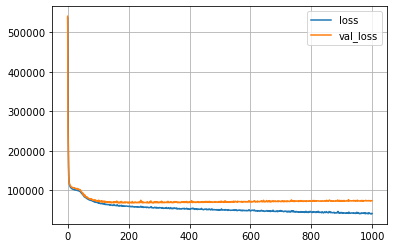

In [14]:
model.compile(loss='mean_absolute_error', optimizer=tf.optimizers.Adam(learning_rate=.01))
train_log = model.fit(X_train, y_train, epochs=500, batch_size=1000, validation_split=.2, verbose=0)
model.evaluate(X_test, y_test)
plot_loss(train_log)

### Early Stopping

Early stopping is very common with neural networks, due to the common pattern mentioned above of the optimal balance of over/under fitting occuring at some point within many, potentially dozens/hundreds/thousands, of epochs. Early stopping kills the process after it detects that validation loss is going back up. 

We can put early stopping in place by using a Keras function called a callback, which has odd syntax, but is quite simple to use. The patience pararmeter controls how many epcohs of worsening scores are tolerated before implementing the stop. The restore_best_weights tells the model to roll back all of its weights to the optimal point - so we automatically get the best model post-training. 

In most cases we probabyl want to use early stopping along with a high epoch number. We can let the model train, and just tell us when it is finished. 

In [15]:
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(X_train))

model = Sequential()
model.add(normalizer)
model.add(Dense(18, input_dim=18, activation='relu'))
model.add(Dense(18, activation='relu'))
model.add(Dense(18, activation='relu'))
model.add(Dense(1))
#model.summary()

169/169 [==============================] - 0s 1ms/step - loss: 68510.4297


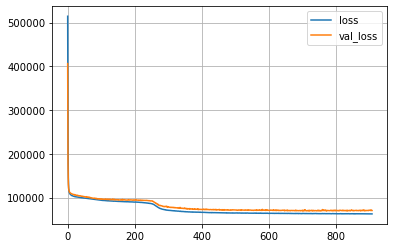

In [16]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=50, restore_best_weights=True) 

model.compile(loss='mean_absolute_error', optimizer=tf.optimizers.Adam(learning_rate=.01))
train_log = model.fit(X_train, y_train, epochs=500, batch_size=100, validation_split=.2, verbose=0, callbacks=[callback])
model.evaluate(X_test, y_test)
plot_loss(train_log)

### Regularization

Like other linear models, we can implement regularization to help tame overfitting. 

We can use both L2 (Ridge) regularization that will limit growth of coefficients, and L1 (Lasso) regularization that is able to eliminate features by shrinking their coefficients to 0. The functionality is the same as we are used to, a regularization term is added to the loss, and the optimization, such as gradient descent, is then performed as normal. 

In [17]:
# Regularization
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(X_train))

model = Sequential()
model.add(normalizer)
model.add(Dense(128, input_dim=18, activation='relu'))
model.add(Dense(128, activation='relu', kernel_regularizer="l1"))
model.add(Dense(128, activation='relu', kernel_regularizer="l2"))
model.add(Dense(1))
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_4 (Normalizat  (None, 18)               37        
 ion)                                                            
                                                                 
 dense_14 (Dense)            (None, 128)               2432      
                                                                 
 dense_15 (Dense)            (None, 128)               16512     
                                                                 
 dense_16 (Dense)            (None, 128)               16512     
                                                                 
 dense_17 (Dense)            (None, 1)                 129       
                                                                 
Total params: 35,622
Trainable params: 35,585
Non-trainable params: 37
_________________________________________________

169/169 [==============================] - 0s 1ms/step - loss: 67661.2031


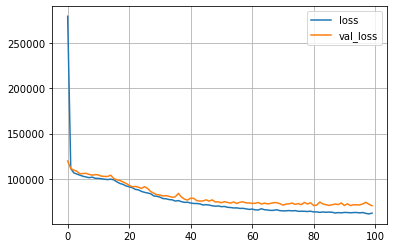

In [18]:
model.compile(loss='mean_absolute_error', optimizer=tf.optimizers.Adam(learning_rate=.01))
train_log = model.fit(X_train, y_train, epochs=100, batch_size=100, validation_split=.2, verbose=0)
model.evaluate(X_test, y_test)
plot_loss(train_log)

### Dropout

Neural networks also commonly employ a technique call dropouts to prevent overfitting. This works just like the name says, every time the data is moved from one layer to another some portion of the features are randomly held out from being used. The intuitive explanation for dropout is that because individual nodes in the network cannot rely on the output of the others, each node must output features that are useful on their own. This sounds somewhat weird, but is actually effective. The number of features held out is called the dropout rate, typically between .2 and .5. 

An analogy can be drawn to the bootstrapping we looked at with trees - some random subset of features is selected each time, resulting in each batch getting "a slightly different look at the data", thus preventing overfitting. 

In [19]:
# Dropout
#Test Different Model Capacities
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(X_train))

model = Sequential()
model.add(normalizer)
model.add(Dense(512, input_dim=18, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu'))
model.add(Dense(1))
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_5 (Normalizat  (None, 18)               37        
 ion)                                                            
                                                                 
 dense_18 (Dense)            (None, 512)               9728      
                                                                 
 dense_19 (Dense)            (None, 512)               262656    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_20 (Dense)            (None, 512)               262656    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                      

169/169 [==============================] - 1s 6ms/step - loss: 71829.8359


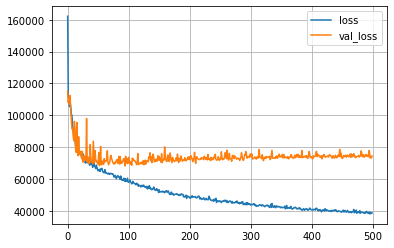

In [20]:
model.compile(loss='mean_absolute_error', optimizer=tf.optimizers.Adam(learning_rate=.01))
train_log = model.fit(X_train, y_train, epochs=500, batch_size=100, validation_split=.2, verbose=0)
model.evaluate(X_test, y_test)
plot_loss(train_log)

### Predictions

Once the model is trained, using it is mostly familiar to us from the sklearn stuff. 

In [21]:
preds = model.predict(X_test)
mean_absolute_error(y_test, preds)


71829.8403049246

### Exercise

Use the California data from previously and try to add some regularization things.

### Customized Loss

Most scenarios are totally fine with a standard loss function, but what if we have something odd? What if we are playing on The Price is Right? We want to get as close as we can, without going over. We can write a loss function to mirror that!

More practically, some real life scenarios have a disperse impact of different types of error. For example, if you are working for a call centre and predicting the number of agents to staff. Having slightly too many may be an error that costs a little bit of money, but not that big of a deal. Predicting too few might incur serious penalties if callers wait and you violate an SLA. Being off in one direction is bad, being off in the other direction can cause you to "fall off of a cliff" so to speak. In cases where the impact of the error is not uniform, custom loss functions may make sense. 

In [22]:
def priceIsRight(y_true, y_pred):
    if y_pred <= y_true:
        return (y_true - y_pred) ** 2
    else:
        return (y_true - y_pred) ** 4

## Optional Exercise

Try to use the California data with a customized loss function. 

Note: this is a 20 way classification, so you'll probably want that many neurons on the output layer, an appropriate activation (softmax), and the y values will need to be run through np_utils.to_categorical. As well, think about the loss function, try categorical crossentropy.

We'll look at activation and loss functions more next week. 

## Big Exercise - Newsgroup Classification

Try to classify the newsgroup data. 

In [23]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

remove = ("headers", "footers", "quotes")

data_train = fetch_20newsgroups(
    subset="train", shuffle=True, remove=remove)

data_test = fetch_20newsgroups(
    subset="test", shuffle=True, remove=remove)

In [24]:
news_tf = TfidfVectorizer(sublinear_tf=True, ngram_range=(1,3), stop_words="english", strip_accents="unicode")
X_train = news_tf.fit_transform(data_train.data)
y_train = data_train.target
X_test = news_tf.transform(data_test.data)
y_test = data_test.target
print("Train:", X_train.shape, "  Test:", X_test.shape)

Train: (11314, 1971374)   Test: (7532, 1971374)


In [25]:
y_test = np_utils.to_categorical(y_test)
y_train = np_utils.to_categorical(y_train)

In [26]:
in_size = 200
tsvd = TruncatedSVD(n_components=in_size)
X_train = tsvd.fit_transform(X_train)
X_test = tsvd.transform(X_test)

In [ ]:
model = Sequential()
model.add(Dense(in_size*3, input_dim=in_size, activation='relu'))
model.add(Dense(in_size*3, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(in_size*3, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(in_size*2, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(in_size*2, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(in_size, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(in_size, activation='relu'))
model.add(Dense(20, activation="softmax"))
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_53 (Dense)            (None, 600)               120600    
                                                                 
 dense_54 (Dense)            (None, 600)               360600    
                                                                 
 dropout_32 (Dropout)        (None, 600)               0         
                                                                 
 dense_55 (Dense)            (None, 600)               360600    
                                                                 
 dropout_33 (Dropout)        (None, 600)               0         
                                                                 
 dense_56 (Dense)            (None, 400)               240400    
                                                                 
 dropout_34 (Dropout)        (None, 400)              

Epoch 1/100
91/91 [==============================] - 2s 11ms/step - loss: 2.7730 - accuracy: 0.1015 - val_loss: 2.5135 - val_accuracy: 0.1436
Epoch 2/100
91/91 [==============================] - 1s 9ms/step - loss: 2.0940 - accuracy: 0.2654 - val_loss: 1.8665 - val_accuracy: 0.3411
Epoch 3/100
91/91 [==============================] - 1s 10ms/step - loss: 1.5779 - accuracy: 0.4559 - val_loss: 1.4100 - val_accuracy: 0.5369
Epoch 4/100
91/91 [==============================] - 1s 9ms/step - loss: 1.2894 - accuracy: 0.5760 - val_loss: 1.2725 - val_accuracy: 0.6019
Epoch 5/100
91/91 [==============================] - 1s 9ms/step - loss: 1.1379 - accuracy: 0.6346 - val_loss: 1.2396 - val_accuracy: 0.6178
Epoch 6/100
91/91 [==============================] - 1s 9ms/step - loss: 1.0170 - accuracy: 0.6742 - val_loss: 1.2824 - val_accuracy: 0.6160
Epoch 7/100
91/91 [==============================] - 1s 10ms/step - loss: 0.9123 - accuracy: 0.7062 - val_loss: 1.2385 - val_accuracy: 0.6407
Epoch 8/10

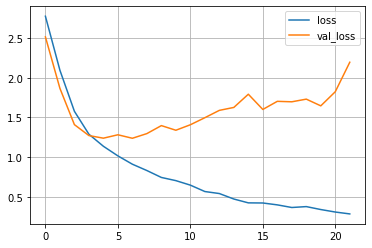

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True) 

model.compile(loss="categorical_crossentropy", optimizer="Adam", metrics=["accuracy"])
train_log = model.fit(X_train, y_train, epochs=100, batch_size=100, validation_split=.2, verbose=1, callbacks=[callback])
model.evaluate(X_test, y_test)
plot_loss(train_log)

## Neural Network Tuning Summary vs Reality

The techniques above generally expose a pattern that we can use to make accurate models:
<ul>
<li> Create a model that is accurate and overfitted. (Or setup process to generate an overfitted model)
<li> Use hyperparameter tuning-ish methods to trial several different models. 
<li> Use tools such as regularization and early stopping to "trim" the overfitting back. 
</ul>

For the most part, for what we are doing, this will probably work fine, without forcing us to put a tonne of thought into things upfront; we can just make a massive model, then reduce it. In practice the main downside to this type of brute force approach is time, and by extension, cost. For us the datasets are mostly small enough that in an extreme case we could do something like setup a bunch of trials, let our computer train and test overnight, and wake up to a model that is pretty good. If our data was scaled up by a factor of 10,000 this becomes less practical. We would want to sample the data to make each trial run much more quickly, but we'd still be dealing with a non-trivial amount of processing time for each model that we want to try. Doing things that reduce the processing requirements of each epoch, such as feature selection, choosing a "correctly" sized model, or smart sets of hyperparameters to try, will reduce the amount of "bad" trials, and allow us to dedicate more time to "good" trials. This is one of the, relatively rare, scenarios that paying attention to processing time can have massive impacts on the end results. 